In [3]:
# ESSENTIAL: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")


In [23]:
import shap
shap.initjs()

In [6]:
df = pd.read_csv("../data/raw/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64
Fraud ratio:  0.001727485630620034
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Time        284807 non-null  float64
 1   V1          284807 non-null  float64
 2   V2          284807 non-null  float64
 3   V3          284807 non-null  float64
 4   V4          284807 non-null  float64
 5   V5          284807 non-null  float64
 6   V6          284807 non-null  float64
 7   V7          284807 non-null  float64
 8   V8          284807 non-null  float64
 9   V9          284807 non-null  float64
 10  V10         284807 non-null  float64
 11  V11         284807 non-null  float64
 12  V12         284807 non-null  float64
 13  V13         284807 non-null  float64
 14  V14         284807 non-null  float64
 15  V15         284807 non-null  float64
 16  V16         284807 non-null  float64


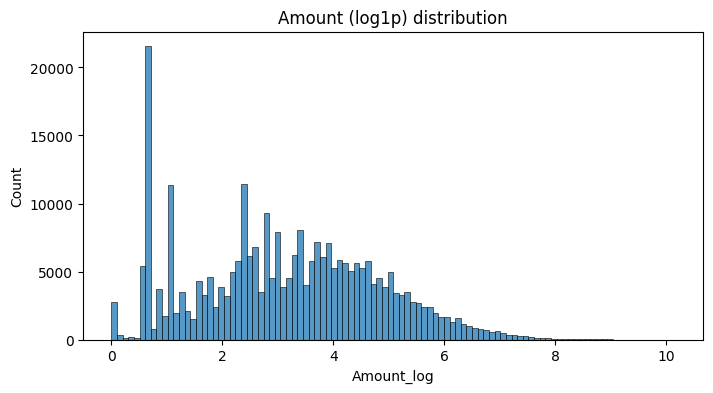

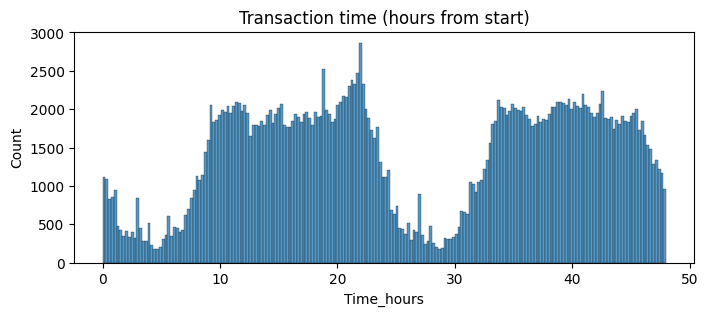

In [8]:
# class balance
print(df['Class'].value_counts())
print("Fraud ratio: ", df['Class'].mean())

# check types & missing
print(df.info())
print(df.isnull().sum().sum())

# Amount distribution (log)
df['Amount_log'] = np.log1p(df['Amount'])
plt.figure(figsize=(8,4))
sns.histplot(df['Amount_log'], bins=100)
plt.title("Amount (log1p) distribution")
plt.show()

# If Time is relative seconds since first transaction (as Kaggle), convert to hours/days
df['Time_hours'] = df['Time'] / 3600.0
plt.figure(figsize=(8,3))
sns.histplot(df['Time_hours'], bins=200)
plt.title("Transaction time (hours from start)")
plt.show()

In [10]:
# keep original PCA features; add normalized amount and time features
features = [f"V{i}" for i in range(1,29)] + ['Amount_log', 'Time_hours']
X = df[features].copy()
y = df['Class'].astype(int).copy()

In [12]:
# sort by Time
df_sorted = df.sort_values('Time').reset_index(drop=True)
cut1 = int(len(df_sorted)*0.7)  # train ~70%
cut2 = int(len(df_sorted)*0.85) # val ~15%, test ~15%
train_df = df_sorted.iloc[:cut1]
val_df   = df_sorted.iloc[cut1:cut2]
test_df  = df_sorted.iloc[cut2:]

X_train = train_df[features]; y_train = train_df['Class'].astype(int)
X_val   = val_df[features];   y_val   = val_df['Class'].astype(int)
X_test  = test_df[features];  y_test  = test_df['Class'].astype(int)

print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)
print("Train fraud ratio:", y_train.mean(), "Val:", y_val.mean(), "Test:", y_test.mean())

Train/Val/Test sizes: (199364, 30) (42721, 30) (42722, 30)
Train fraud ratio: 0.0019261250777472363 Val: 0.001310830738980829 Test: 0.0012171714807359207


In [14]:
from sklearn.compose import ColumnTransformer
# Everything numeric here; use RobustScaler to reduce influence of Amount outliers
scaler = RobustScaler()

# Logistic baseline (class_weight)
log_pipe = ImbPipeline([
    ('scaler', scaler),
    # no SMOTE for logistic baseline (try both ways in experiments)
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# RandomForest baseline (balanced subsampling)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
rf_pipe = ImbPipeline([
    ('scaler', scaler),
    ('clf', rf)
])

# XGBoost candidate with SMOTE
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1, # we'll balance via SMOTE
    random_state=42,
    n_jobs=-1
)
xgb_pipe = ImbPipeline([
    ('scaler', scaler),
    ('smote', SMOTE(random_state=42)),
    ('clf', xgb_clf)
])

In [16]:
def evaluate_model(pipe, X_tr, y_tr, X_val, y_val, k_alerts=100):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_val)[:,1]
    ap = average_precision_score(y_val, proba)  # PR-AUC
    # precision@k: sort by proba, check top k alerts
    topk_idx = np.argsort(proba)[-k_alerts:]
    precision_at_k = y_val.iloc[topk_idx].sum() / k_alerts
    # pick threshold via precision-recall curve (you can pick threshold for desired recall)
    prec, rec, thr = precision_recall_curve(y_val, proba)
    # pick threshold maximizing F1
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    preds = (proba >= best_thr).astype(int)
    p = precision_score(y_val, preds)
    r = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    return {'ap':ap, 'precision_at_k':precision_at_k, 'best_thr':best_thr, 'precision':p, 'recall':r, 'f1':f1}

# Evaluate
for name, model in [('Logistic', log_pipe), ('RandomForest', rf_pipe), ('XGBoost+SMOTE', xgb_pipe)]:
    res = evaluate_model(model, X_train, y_train, X_val, y_val, k_alerts=100)
    print(name, res)

Logistic {'ap': 0.8234680623336087, 'precision_at_k': np.float64(0.48), 'best_thr': np.float64(0.9999789321961708), 'precision': 0.8571428571428571, 'recall': 0.75, 'f1': 0.8}
RandomForest {'ap': 0.868996938284634, 'precision_at_k': np.float64(0.49), 'best_thr': np.float64(0.28), 'precision': 1.0, 'recall': 0.7857142857142857, 'f1': 0.88}
XGBoost+SMOTE {'ap': 0.8284170450191177, 'precision_at_k': np.float64(0.46), 'best_thr': np.float32(0.9410918), 'precision': 1.0, 'recall': 0.75, 'f1': 0.8571428571428571}


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_space = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [4,6,8],
    'clf__learning_rate': [0.01,0.05,0.1],
    'smote__k_neighbors': [3,5,7]
}

rand = RandomizedSearchCV(xgb_pipe, param_space, n_iter=12, scoring='average_precision', cv=3, verbose=2, n_jobs=4)
rand.fit(X_train, y_train)
print("Best params:", rand.best_params_)
best_pipe = rand.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__learning_rate=0.01, clf__max_depth=6, clf__n_estimators=100, smote__k_neighbors=3; total time=   8.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=8, clf__n_estimators=200, smote__k_neighbors=3; total time=  21.4s
[CV] END clf__learning_rate=0.05, clf__max_depth=8, clf__n_estimators=200, smote__k_neighbors=3; total time=  21.7s
[CV] END clf__learning_rate=0.01, clf__max_depth=6, clf__n_estimators=100, smote__k_neighbors=3; total time=  15.2s
[CV] END clf__learning_rate=0.05, clf__max_depth=8, clf__n_estimators=200, smote__k_neighbors=3; total time=  24.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=6, clf__n_estimators=100, smote__k_neighbors=3; total time=  11.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=6, clf__n_estimators=400, smote__k_neighbors=3; total time=  34.6s
[CV] END clf__learning_rate=0.05, clf__max_depth=6, clf__n_estimators=400, smote__k_neighbors=3; total time=  32.2s
[CV] END cl

In [18]:
# Combine train + val for final training
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

best_pipe.fit(X_trainval, y_trainval)
proba_test = best_pipe.predict_proba(X_test)[:,1]
ap_test = average_precision_score(y_test, proba_test)
print("Test PR-AUC:", ap_test)

# choose threshold by maximizing F1 on trainval (or minimizing business cost)
prec, rec, thr = precision_recall_curve(y_trainval, best_pipe.predict_proba(X_trainval)[:,1])
f1s = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
chosen_threshold = thr[best_idx] if best_idx < len(thr) else 0.5
print("Chosen threshold:", chosen_threshold)

# compute test metrics using chosen_threshold
preds_test = (proba_test >= chosen_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))

Test PR-AUC: 0.7638945665309009
Chosen threshold: 0.9466428
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42670
           1       0.85      0.75      0.80        52

    accuracy                           1.00     42722
   macro avg       0.92      0.87      0.90     42722
weighted avg       1.00      1.00      1.00     42722

[[42663     7]
 [   13    39]]


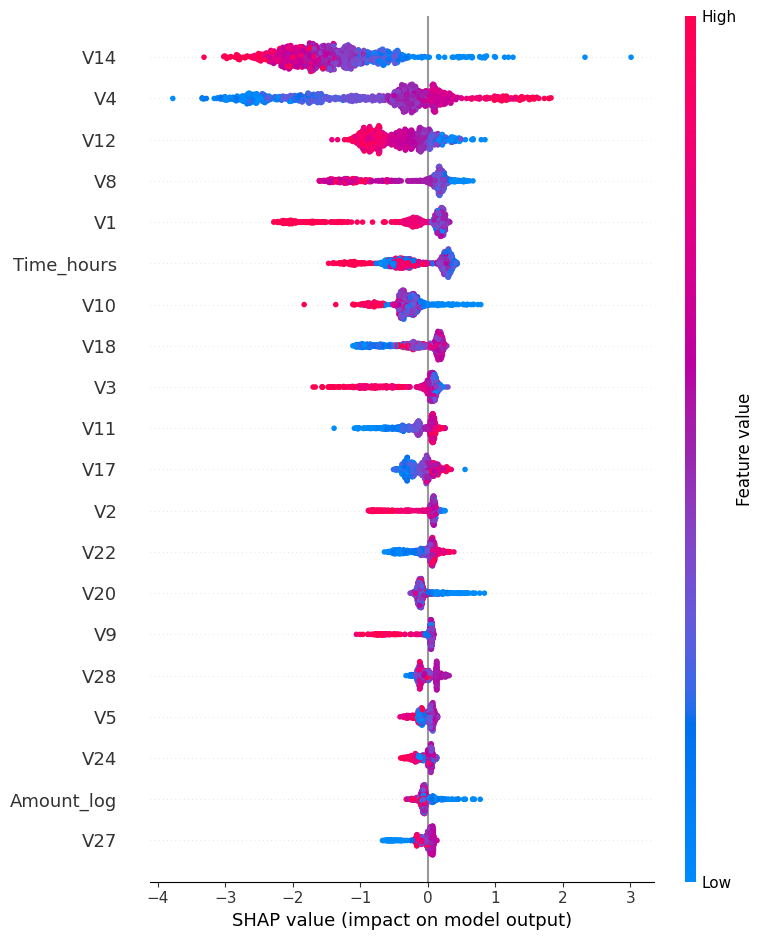

In [24]:
# Explainer for tree-based model
# If pipeline contains SMOTE/scaler, extract trained XGBoost estimator and use original features
xgb_model = best_pipe.named_steps['clf']  # if pipeline structure differs adjust accordingly
# Create explainer on a background sample from trainval (use scaled/unscaled correctly)
# best_pipe has scaler: we need to transform features before passing to explainer
X_bg = X_trainval.sample(1000, random_state=42)
X_bg_scaled = best_pipe.named_steps['scaler'].transform(X_bg)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_bg_scaled)

# Save explainer (or save model + scaler and recompute explainer in production)
joblib.dump(explainer, "../models/xgb_shap_explainer.joblib")
joblib.dump(best_pipe, "../models/xgb_pipeline.joblib")

# Example plots (global and single instance)
shap.summary_plot(shap_values, X_bg_scaled, feature_names=X_bg.columns.tolist())
# For a single transaction from test set:
idx = 5
x_test_scaled = best_pipe.named_steps['scaler'].transform(X_test.iloc[[idx]])
sv = explainer.shap_values(x_test_scaled)
shap.force_plot(explainer.expected_value, sv, feature_names=X_test.columns.tolist())  # in notebook

In [28]:
joblib.dump(best_pipe, "../models/final_pipeline_xgb.joblib")
# Save chosen threshold and metadata
import json
meta = {'threshold': float(chosen_threshold), 'model':'xgboost+smote', 'date': str(pd.Timestamp.now())}
with open("../models/metadata.json", "w") as f:
    json.dump(meta, f)

              precision    recall  f1-score   support

           0     0.9997    0.9996    0.9996     42670
           1     0.7037    0.7308    0.7170        52

    accuracy                         0.9993     42722
   macro avg     0.8517    0.8652    0.8583     42722
weighted avg     0.9993    0.9993    0.9993     42722

ROC-AUC: 0.9693193290187666


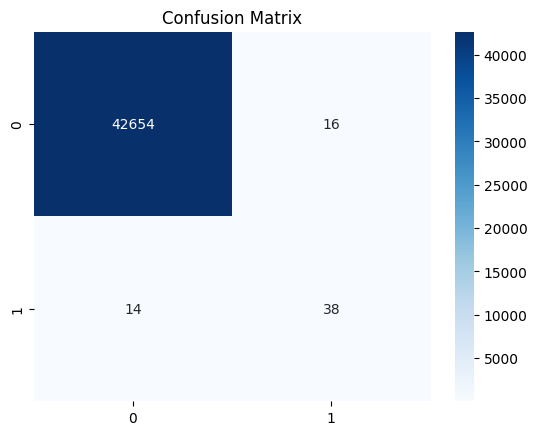

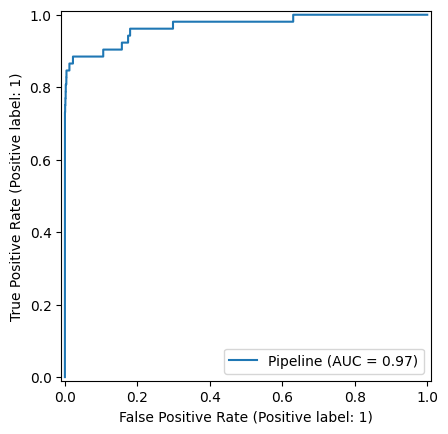

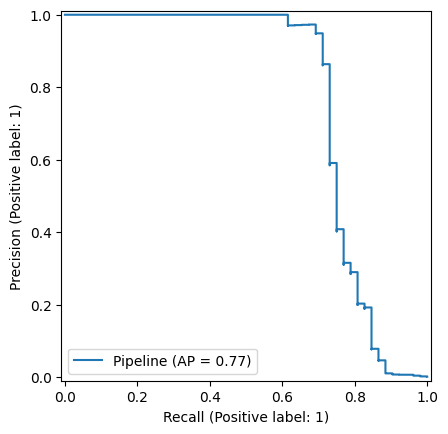

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.show()

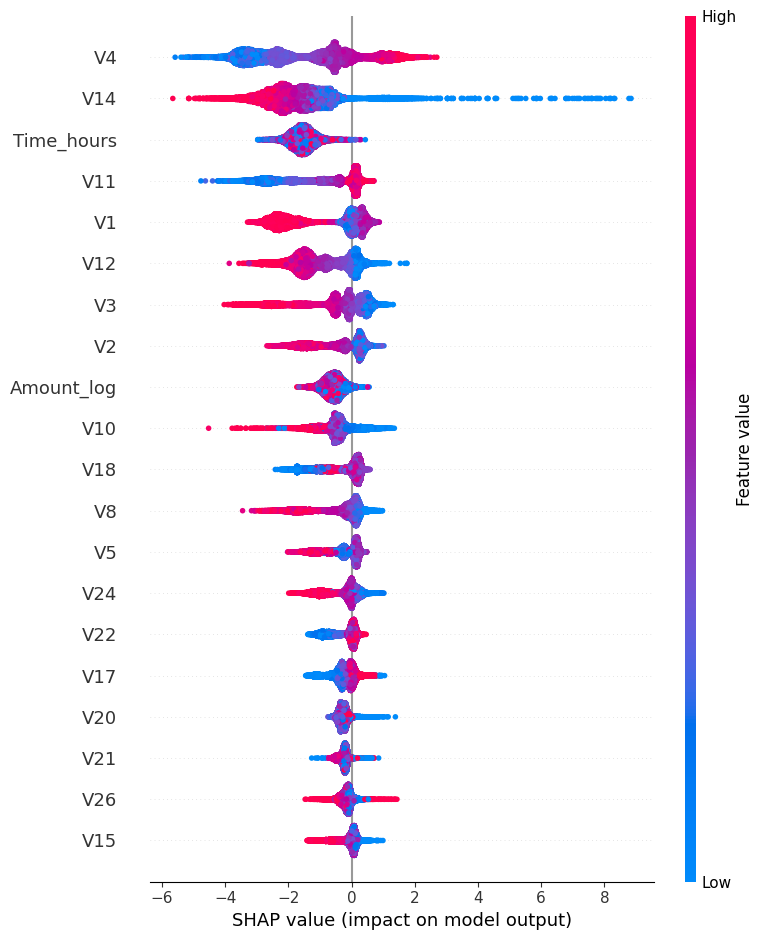

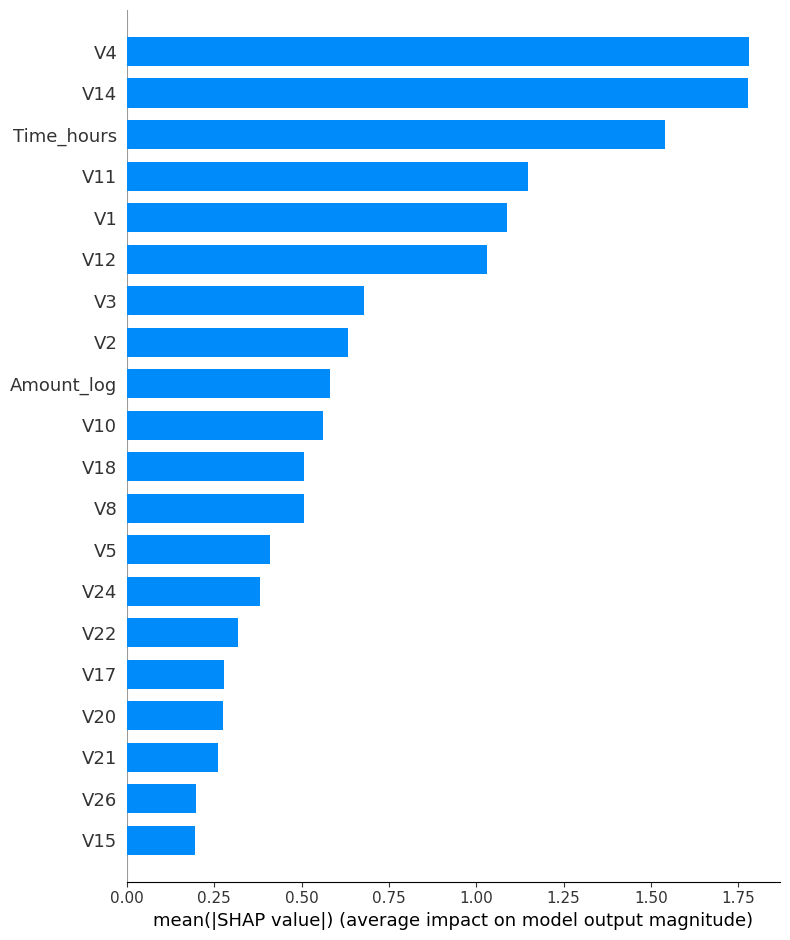

In [34]:
import shap

shap.initjs()  # initialize JS visualizations

explainer = shap.TreeExplainer(model.named_steps['clf'])  # use 'clf' instead of 'classifier'
shap_values = explainer.shap_values(X_test)

# summary plot (dots)
shap.summary_plot(shap_values, X_test)

# summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [36]:
import joblib
joblib.dump(model, "fraud_detection_model.pkl")


['fraud_detection_model.pkl']

In [37]:
model = joblib.load("fraud_detection_model.pkl")
